In [56]:
import imageio
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout, AveragePooling2D, Flatten, Dropout, LSTM, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [57]:
def preprocess_imagery(path):
    '''
    Pre process satellite imagery. We check for nans in the composite images,
    and then we load them into the [0,1] range.
    Input: TIF files downloaded from GEE (224x224x7)
    '''
    # Reading image
    path = str(path).strip('b').strip("'")
    path="D:/GEE_Images/GEE_Images/"+path+".tif"
    image = (imageio.imread(path))
    """if np.sum(np.isnan(image)) > 0:
        # Taking the mean of the image, per channel
        mean = np.nanmean(image, axis=(0, 1))
        # Replacing NaN with per channel mean
        replacement = np.isnan(image) * mean
        image[np.isnan(image)] = replacement[np.isnan(image)]  
        nan_channels = np.all(np.isnan(image), axis=(0, 1))
        # Replacing NaN with 0 where all values in a channel are NaN
        image[:, :, nan_channels] = np.nan_to_num(image[:, :, nan_channels])
    # Scale the image to [0, 1] range
    image = image / 255"""
    return image

In [24]:
image_files = [f for f in os.listdir("../GEE_Images/GEE_Images")]
image_info = []
df = pd.read_csv('processed_data.csv')

for image in image_files:
    name, _ = os.path.splitext(image)
    # Extraer estación y fecha de las imágenes
    station = '_'.join(name.split(' ')[0].split('_')[:-1])
    date = name.split(' ')[0].split('_')[-1]
    image_info.append([station, date,name])

# Añadimos una columna para asociar imágenes en df
df['image'] = None  # Inicialmente sin imágenes asociadas

# Ahora asociamos cada imagen a su registro en df
for info in image_info:
    df.loc[(df['station'] == info[0]) & (df['Date'] == info[1]), 'image'] = info[2]

# Verificar que las imágenes se han asignado correctamente
print(df.head())


      mp10    station    mp2.5  dirviento  tamb  so2  velviento     hrel  \
0  178.542  El_bosque  49.7829    221.195   NaN  9.5   0.950428  40.5833   
1  178.542  El_bosque  49.7829    221.195   NaN  9.5   0.950428  40.5833   
2  178.542  El_bosque  49.7829    221.195   NaN  9.5   0.950428  40.5833   
3  178.542  El_bosque  49.7829    221.195   NaN  9.5   0.950428  40.5833   
4  146.042  El_bosque  49.7829    221.195   NaN  9.5   0.950428  40.5833   

       no2       o3  ...       no        co  region        Date  Year  Month  \
0  30.3333  16.9167  ...  34.8333  0.929165       1  1997-04-02  1997      4   
1  30.3333  12.4583  ...  34.8333  0.929165       1  1997-04-03  1997      4   
2  30.3333  23.2083  ...  34.8333  0.929165       1  1997-04-04  1997      4   
3  30.3333  28.2917  ...  34.8333  0.929165       1  1997-04-05  1997      4   
4  30.3333  21.2083  ...  34.8333  1.204160       1  1997-04-06  1997      4   

   Day        lat       long  image  
0    2 -33.547016 -70.66

In [26]:
df_Scaled=df.copy()
# Crear un diccionario para almacenar los datos de cada locación
df_Scaled.fillna(value=0,inplace=True)
grouped_data = {location: location_df.sort_values(by='Date') for location, location_df in df_Scaled.groupby('station')}

In [27]:
df['image'].describe()

count                             51782
unique                            51782
top       El_bosque_1997-07-01 00_00_00
freq                                  1
Name: image, dtype: object

### Usando 7 días previos para predecir el día siguiente (Sin capping)

In [28]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [29]:
# Definir la métrica personalizada SMAPE
def smape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()  # Pequeño valor para evitar divisiones por cero
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + epsilon
    diff = tf.abs(y_true - y_pred) / denominator
    return 100.0 * tf.reduce_mean(diff)  # Se devuelve el error en porcentaje


# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        880 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 12, 12,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    589,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 50)     │     13,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     20,200 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     22,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [36]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)


In [37]:
X_train[0].shape

(7, 17)

In [38]:
checkpoint_path = "training/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [39]:
history=model.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)

Epoch 1/50


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_12']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\benja\AppData\Local\Temp\ipykernel_11080\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.0863 - mean_absolute_percentage_error: 136873.1719 - mean_squared_error: 0.5962 - smape: 52.7968
Epoch 1: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 969s 429ms/step - loss: 0.0862 - mean_absolute_percentage_error: 136849.4219 - mean_squared_error: 0.5960 - smape: 52.7951 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 92910.3750 - val_mean_squared_error: 9.1084e-04 - val_smape: 49.0097
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:35 69ms/step - loss: 0.0152 - mean_absolute_percentage_error: 25.2768 - mean_squared_error: 3.5523e-04 - smape: 39.0289
Epoch 2: saving model to training/ckpt.weights.h5


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 96us/step - loss: 0.0152 - mean_absolute_percentage_error: 25.2768 - mean_squared_error: 3.5523e-04 - smape: 19.5231 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 43.6166 - val_mean_squared_error: 7.1978e-04 - val_smape: 21.2371
Epoch 3/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - loss: 0.0187 - mean_absolute_percentage_error: 60771.3320 - mean_squared_error: 8.4582e-04 - smape: 48.6338
Epoch 3: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 915s 406ms/step - loss: 0.0187 - mean_absolute_percentage_error: 60775.0273 - mean_squared_error: 8.4580e-04 - smape: 48.6339 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 92221.3672 - val_mean_squared_error: 8.3083e-04 - val_smape: 48.9478
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 1:59 53ms/step - loss: 0.0135 - mean_absolute_percentage_error: 21.4849 - mean_squared_error: 2.9093e-04 - smape: 43.0578
Epoch 4: saving model to training/ckpt.weights.h5
2253/2253 ━━━

In [40]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()


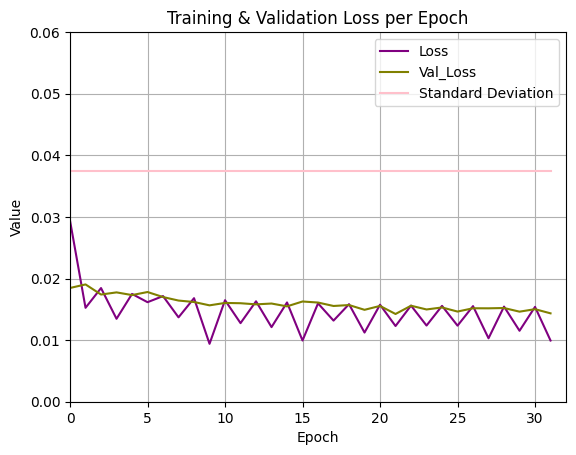

In [41]:
s=[df_Scaled.std()]*len(history.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history.history['loss'],  color='purple',label='Loss')
plt.plot(history.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model.png',format='png')
# Muestra el gráfico
plt.show()

In [42]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict = model.predict(test_dataset,steps=len(y_test))

C:\Users\benja\AppData\Local\Temp\ipykernel_11080\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 205s 10ms/step


In [52]:
# Calcular MAE
mae0 = mean_absolute_error(y_test, predict)
mse0= mean_squared_error(y_test, predict)
# Calcular R-squared
r20= r2_score(y_test, predict)
def smape_2(y_true, y_pred):
    """
    Calcula el Symmetric Mean Absolute Percentage Error.
    """
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))

smape0 = smape_2(y_test, predict)

# Imprimir las métricas
print(f"MAE: {mae0}")
print(f"MSE: {mse0}")
print(f"R-squared: {r20}")
print(f"SMAPE: {smape0}%")

MAE: 0.024951122207249193
MSE: 0.00127273699185358
R-squared: 0.15893306975515364
SMAPE: 36.60100083635075%


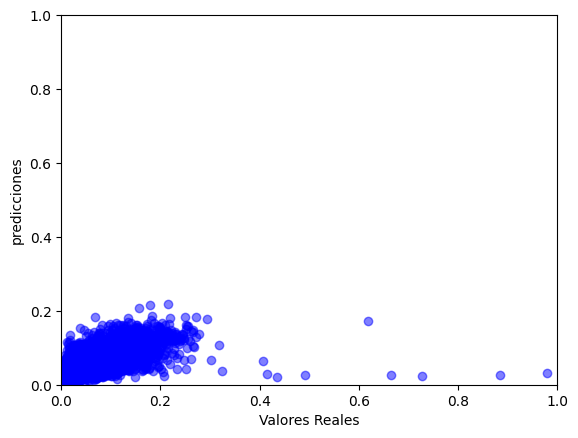

In [44]:
plt.scatter(y_test, predict, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [45]:
df['mp10'].describe()

count    151917.000000
mean         55.948889
std          34.322277
min           0.000000
25%          34.208300
50%          49.000000
75%          69.833300
max         917.940000
Name: mp10, dtype: float64

C:\Users\benja\AppData\Local\Temp\ipykernel_11080\4037668646.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict[a]))


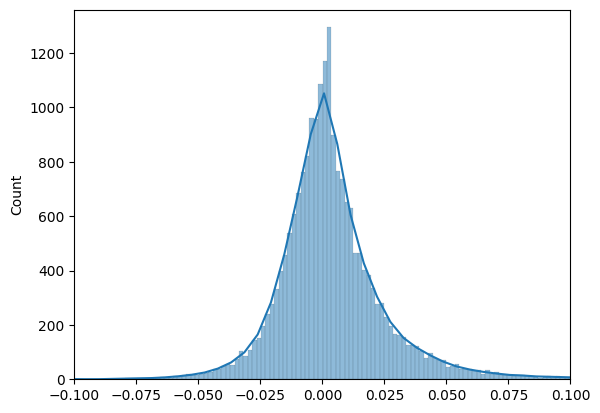

In [46]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 7 días para predecir promedio semanal siguiente (Sin capping)

In [47]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [59]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model1 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model1.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model1.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 222, 222,  │        880 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_8 │ (None, 111, 111,  │          0 │ conv2d_8[0][0]    │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_9 │ (None, 54, 54,    │          0 │ conv2d_9[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_10[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_11[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    589,952 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 7, 50)     │     13,600 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 50)        │     20,200 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 178)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     22,912 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [50]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_1/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [60]:
history1=model1.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_38', 'keras_tensor_50']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\benja\AppData\Local\Temp\ipykernel_11080\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - loss: 0.0712 - mean_absolute_percentage_error: 17598.3320 - mean_squared_error: 0.4275 - smape: 46.2698
Epoch 1: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1435s 635ms/step - loss: 0.0712 - mean_absolute_percentage_error: 17599.0254 - mean_squared_error: 0.4273 - smape: 46.2686 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 25639.5820 - val_mean_squared_error: 7.0605e-04 - val_smape: 43.0074
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:33 68ms/step - loss: 0.0130 - mean_absolute_percentage_error: 19.6545 - mean_squared_error: 2.3933e-04 - smape: 34.1130
Epoch 2: saving model to training_1/ckpt.weights.h5


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - loss: 0.0130 - mean_absolute_percentage_error: 19.6545 - mean_squared_error: 2.3933e-04 - smape: 17.0641 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 19.8043 - val_mean_squared_error: 4.5007e-04 - val_smape: 17.5535
Epoch 3/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - loss: 0.0185 - mean_absolute_percentage_error: 18074.3438 - mean_squared_error: 7.8881e-04 - smape: 43.5300
Epoch 3: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1993s 885ms/step - loss: 0.0185 - mean_absolute_percentage_error: 18074.7988 - mean_squared_error: 7.8881e-04 - smape: 43.5301 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 25779.6250 - val_mean_squared_error: 6.5755e-04 - val_smape: 44.2419
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 1:50 49ms/step - loss: 0.0096 - mean_absolute_percentage_error: 13.9618 - mean_squared_error: 1.3312e-04 - smape: 32.2919
Epoch 4: saving model to training_1/ckpt.weights.h5
2253/225

In [61]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

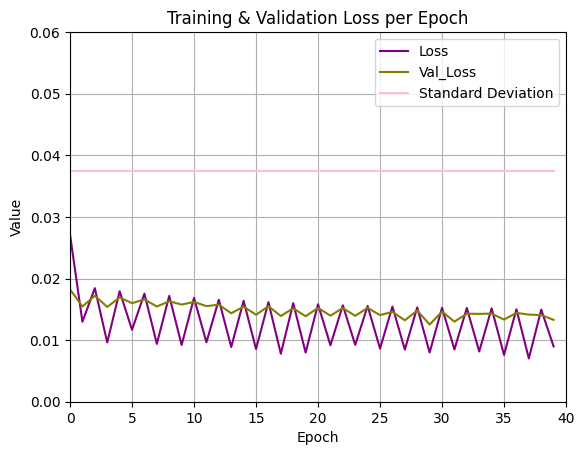

In [62]:
s=[df_Scaled.std()]*len(history1.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history1.history['loss'],  color='purple',label='Loss')
plt.plot(history1.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history1.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model1.png',format='png')
# Muestra el gráfico
plt.show()

In [63]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict1 = model1.predict(test_dataset,steps=len(y_test))

C:\Users\benja\AppData\Local\Temp\ipykernel_11080\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 301s 15ms/step


In [64]:
# Calcular MAE
mae1 = mean_absolute_error(y_test, predict1)
mse1= mean_squared_error(y_test, predict1)
# Calcular R-squared
r21 = r2_score(y_test, predict1)
smape1 = smape_2(y_test, predict1)

# Imprimir las métricas
print(f"MAE: {mae1}")
print(f"MSE: {mse1}")
print(f"R-squared: {r21}")
print(f"SMAPE: {smape1}%")

MAE: 0.015039202210330043
MSE: 0.0006509588000405462
R-squared: 0.569824776705353
SMAPE: 20.962979259932805%


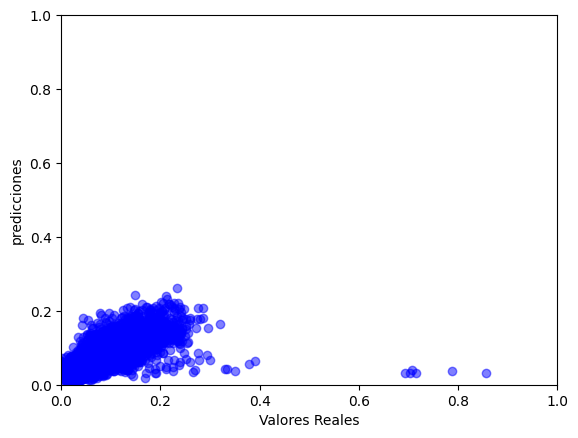

In [65]:
plt.scatter(y_test, predict1, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_11080\101343474.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict1[a]))


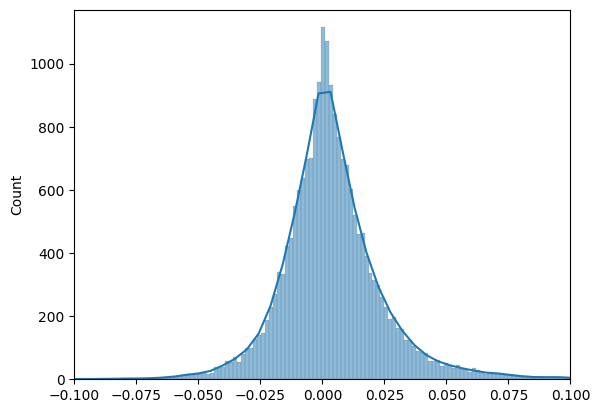

In [66]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict1[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el día siguiente (Sin capping)

In [67]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (123013, 10, 17), Forma de y: (123013, 1), Total de imágenes: (123013,)
Train set: X=(86109, 10, 17), y=(86109, 1), images=(86109,)
Test set: X=(24725, 10, 17), y=(24725, 1), images=(24725,)
Validation set: X=(12179, 10, 17), y=(12179, 1), images=(12179,)


In [68]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model2 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model2.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model2.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 222, 222,  │        880 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 111, 111,  │          0 │ conv2d_12[0][0]   │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 54, 54,    │          0 │ conv2d_13[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_14[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_15[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │    589,952 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 10, 50)    │     13,600 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 50)        │     20,200 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 178)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     22,912 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        129 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [70]:
checkpoint_path = "training_2/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [71]:
history2=model2.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_57', 'keras_tensor_69']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\benja\AppData\Local\Temp\ipykernel_11080\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


 462/2690 ━━━━━━━━━━━━━━━━━━━━ 19:59 538ms/step - loss: 0.3334 - mean_absolute_percentage_error: 3674381.0000 - mean_squared_error: 3.2806 - smape: 65.1855

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*len(history2.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history2.history['loss'],  color='purple',label='Loss')
plt.plot(history2.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history2.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model2.png',format='png')
# Muestra el gráfico
plt.show()

In [ ]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict2 = model2.predict(test_dataset,steps=len(y_test))

In [ ]:

mae2 = mean_absolute_error(y_test, predict2)
mse2= mean_squared_error(y_test, predict2)
r22 = r2_score(y_test, predict2)
smape2 = smape_2(y_test, predict2)

# Imprimir las métricas
print(f"MAE: {mae2}")
print(f"MSE: {mse2}")
print(f"R-squared: {r22}")
print(f"SMAPE: {smape2}%")

In [ ]:
plt.scatter(y_test, predict2, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [ ]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict2[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el promedio de la semana siguiente (Sin capping)

In [ ]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


In [ ]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model3 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model3.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model3.summary()


In [ ]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [ ]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_3/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history3=model3.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


In [ ]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*len(history3.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history3.history['loss'],  color='purple',label='Loss')
plt.plot(history3.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history3.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model3.png',format='png')
# Muestra el gráfico
plt.show()

In [ ]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict3 = model3.predict(test_dataset,steps=len(y_test))

In [ ]:
# Calcular MAE
mae3 = mean_absolute_error(y_test, predict3)
mse3= mean_squared_error(y_test, predict3)
# Calcular R-squared
r23 = r2_score(y_test, predict3)

smape3 = smape_2(y_test, predict3)

# Imprimir las métricas
print(f"MAE: {mae3}")
print(f"MSE: {mse3}")
print(f"R-squared: {r23}")
print(f"SMAPE: {smape3}%")

In [ ]:
plt.scatter(y_test, predict3, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [ ]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict3[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 7 días para predecir día siguiente (Capping)

In [5]:
# Calcular la media y la desviación estándar
mean = df['mp10'].mean()
std = df['mp10'].std()

# Definir límites usando múltiplos de la desviación estándar (ej. 3 desviaciones estándar)
lower_cap = mean - 3 * std  # Límite inferior: media - 3 veces la desviación estándar
upper_cap = mean + 3 * std  # Límite superior: media + 3 veces la desviación estándar

# Aplicar el capping
df['mp10'] = df['mp10'].clip(lower=lower_cap, upper=upper_cap)

In [26]:
df['mp10'].describe()

count    151917.000000
mean         55.373795
std          31.277526
min           0.000000
25%          34.208300
50%          49.000000
75%          69.833300
max         158.915720
Name: mp10, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dropout
import tensorflow as tf
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model4 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model4.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model4.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        880 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 12, 12,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    589,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 50)     │     13,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     20,200 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     22,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [10]:
checkpoint_path = "training_4/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [11]:
history4=model4.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)




Epoch 1/50


C:\Users\benja\AppData\Local\Temp\ipykernel_1964\3065549325.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.0505 - mean_absolute_percentage_error: 163444.3281 - mean_squared_error: 0.1118 - smape: 51.7397
Epoch 1: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 673s 297ms/step - loss: 0.0505 - mean_absolute_percentage_error: 163410.6406 - mean_squared_error: 0.1118 - smape: 51.7384 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 91616.1250 - val_mean_squared_error: 9.0473e-04 - val_smape: 48.6110
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:15 60ms/step - loss: 0.0137 - mean_absolute_percentage_error: 21.7818 - mean_squared_error: 2.8444e-04 - smape: 40.1053
Epoch 2: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 51us/step - loss: 0.0137 - mean_absolute_percentage_error: 21.7818 - mean_squared_error: 2.8444e-04 - smape: 20.0616 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 41.3462 - val_mean_squared_error: 6.4494e-04 - val_smape: 20.5652
Epoch 3/50


c:\Users\benja\anaconda3\envs\ee\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0185 - mean_absolute_percentage_error: 60291.5391 - mean_squared_error: 8.2490e-04 - smape: 48.8690
Epoch 3: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 653s 290ms/step - loss: 0.0185 - mean_absolute_percentage_error: 60295.8086 - mean_squared_error: 8.2488e-04 - smape: 48.8690 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 90374.1562 - val_mean_squared_error: 8.2373e-04 - val_smape: 48.3642
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 1:47 48ms/step - loss: 0.0131 - mean_absolute_percentage_error: 21.9665 - mean_squared_error: 2.8226e-04 - smape: 45.7451
Epoch 4: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - loss: 0.0131 - mean_absolute_percentage_error: 21.9665 - mean_squared_error: 2.8226e-04 - smape: 22.8827 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 39.5616 - val_mean_squared_error: 5.2449e-04 - val_smape: 19.7700
Epoch 5/50
2253/2253

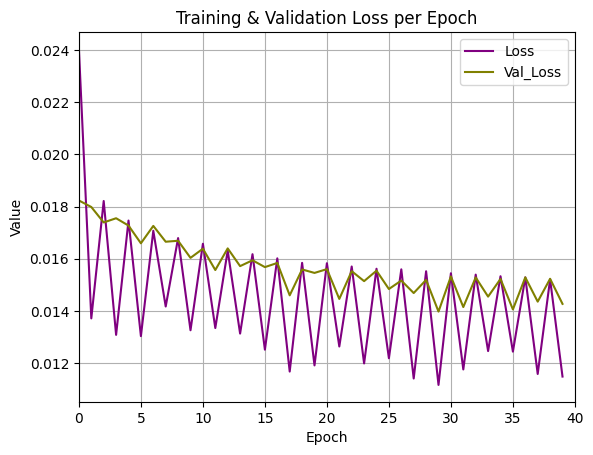

In [20]:
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history4.history['loss'],  color='purple',label='Loss')
plt.plot(history4.history['val_loss'],color='olive',label='Val_Loss')

# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history4.history['loss']))

plt.legend()

plt.grid(True)
# Muestra el gráfico
plt.show()

In [21]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict4 = model4.predict(test_dataset,steps=len(y_test))

C:\Users\benja\AppData\Local\Temp\ipykernel_1964\3065549325.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 153s 7ms/step


In [22]:
# Calcular MAE
mae4 = mean_absolute_error(y_test, predict4)
mse4= mean_squared_error(y_test, predict4)
# Calcular R-squared
r24 = r2_score(y_test, predict4)
smape4 = smape_2(y_test, predict4)

# Imprimir las métricas
print(f"MAE: {mae4}")
print(f"MSE: {mse4}")
print(f"R-squared: {r24}")
print(f"SMAPE: {smape4}%")

MAE: 0.015102008773863553
MSE: 0.0006616332825548225
R-squared: 0.4864982490820883
SMAPE: 27.643883028920165%


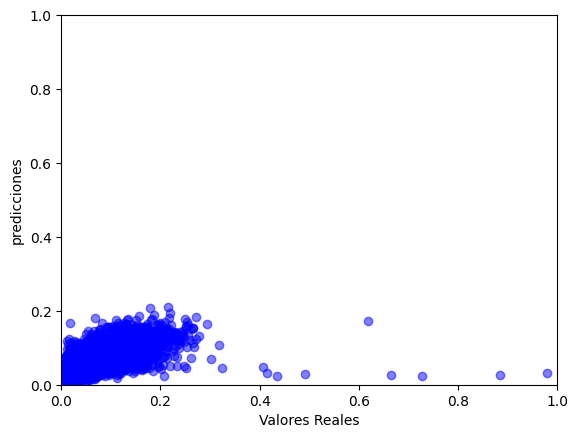

In [23]:
plt.scatter(y_test, predict4, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_1964\4069564214.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(y_test[a]))


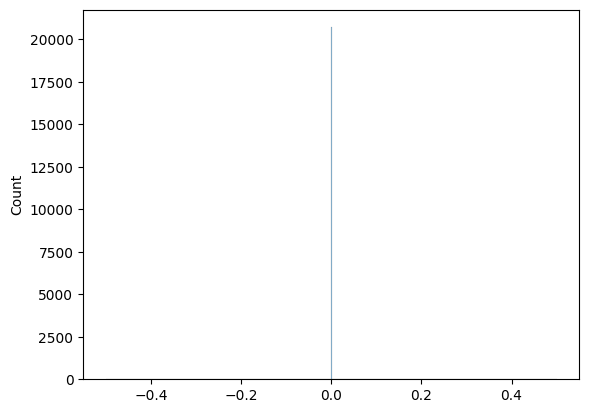

In [27]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict4[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.show()

### Usando 7 días para predecir día siguiente (Capping)

In [ ]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


In [ ]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model5 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model5.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model5.summary()


In [ ]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [ ]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_5/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history5=model5.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

In [ ]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*len(history5.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history5.history['loss'],  color='purple',label='Loss')
plt.plot(history5.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history5.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model5.png',format='png')
# Muestra el gráfico
plt.show()

In [ ]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict5 = model.predict(test_dataset,steps=len(y_test))

In [ ]:
# Calcular MAE
mae5 = mean_absolute_error(y_test, predict5)
mse5= mean_squared_error(y_test, predict5)
# Calcular R-squared
r25 = r2_score(y_test, predict5)
smape5 = smape_2(y_test, predict5)

# Imprimir las métricas
print(f"MAE: {mae5}")
print(f"MSE: {mse5}")
print(f"R-squared: {r25}")
print(f"SMAPE: {smape5}%")

In [ ]:
plt.scatter(y_test, predict5, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [ ]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict5[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el día siguiente (Capping)

In [ ]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


In [ ]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model6 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model6.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model6.summary()


In [ ]:
checkpoint_path = "training_6/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history6=model6.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


In [ ]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()


In [ ]:
s=[df_Scaled.std()]*len(history6.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history6.history['loss'],  color='purple',label='Loss')
plt.plot(history6.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history6.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model6.png',format='png')
# Muestra el gráfico
plt.show()

In [ ]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict6 = model6.predict(test_dataset,steps=len(y_test))

In [ ]:
mae6 = mean_absolute_error(y_test, predict6)
mse6= mean_squared_error(y_test, predict6)
# Calcular R-squared
r26 = r2_score(y_test, predict6)

smape6 = smape_2(y_test, predict6)

# Imprimir las métricas
print(f"MAE: {mae6}")
print(f"MSE: {mse6}")
print(f"R-squared: {r26}")
print(f"SMAPE: {smape6}%")

In [ ]:
plt.scatter(y_test, predict6, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [ ]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict6[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el promedio de la semana siguiente (Capping)

In [ ]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


In [ ]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model7 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model7.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model7.summary()


In [ ]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [ ]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_7/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history7=model7.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


In [ ]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

In [ ]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*len(history7.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history.history['loss'],  color='purple',label='Loss')
plt.plot(history.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history7.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model7.png',format='png')
# Muestra el gráfico
plt.show()

In [ ]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict7 = model.predict(test_dataset,steps=len(y_test))

In [ ]:
# Calcular MAE
mae7 = mean_absolute_error(y_test, predict)
mse7= mean_squared_error(y_test, predict)
# Calcular R-squared
r27 = r2_score(y_test, predict)
smape7 = smape_2(y_test, predict)

# Imprimir las métricas
print(f"MAE: {mae7}")
print(f"MSE: {mse7}")
print(f"R-squared: {r27}")
print(f"SMAPE: {smape7}%")

In [ ]:
plt.scatter(y_test, predict7, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [ ]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict7[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

In [ ]:
mae_list = [mae0, mae1, mae2, mae3, mae4, mae5, mae6, mae7]
mse_list = [mse0, mse1, mse2, mse3, mse4, mse5, mse6, mse7]
r2_list = [r20, r21, r22, r23, r24, r25, r26, r27]
smape_list = [smape0, smape1, smape2, smape3, smape4, smape5, smape6, smape7]

# Crear una lista de modelos del 0 al 7
modelos = list(range(8))

# Crear un diccionario con los datos
data = {
    'Modelo': modelos,
    'MAE': mae,
    'MSE': mse,
    'R2': r2,
    'SMAPE': smape
}

# Crear un DataFrame de pandas con los datos
dfs = pd.DataFrame(data)

# Mostrar el DataFrame
print(dfs)